In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
train = pd.read_csv('../input/sarcasm/train-balanced-sarcasm.csv')

In [3]:
train.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


Удаление пустых комментариев

In [5]:
train.dropna(subset = ['comment'], inplace = True)

In [6]:
train['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

Разбиваем выборку на тренировочную и валидационную

In [7]:
train_texts, valid_texts, y_train, y_valid = \
        train_test_split(train['comment'], train['label'], random_state=17)

### ЗАДАНИЕ 1 АНАЛИЗ ДАННЫХ

Посмотрим на длину комментариев. По гистограмме видно, что длина примерно одинаковая

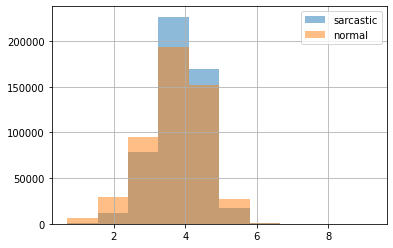

In [8]:
train.loc[train['label'] == 1, 'comment'].str.len().apply(np.log1p).hist(label = 'sarcastic', alpha = 0.5)
train.loc[train['label'] == 0, 'comment'].str.len().apply(np.log1p).hist(label = 'normal', alpha = 0.5)
plt.legend();

Посмотрим на слова, которые чаще всего встречаются в саркастических комментариях и в обычных

In [9]:
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud( background_color = 'black', stopwords = STOPWORDS
                     , max_words = 200, max_font_size = 100
                     , random_state = 17, width = 800, height = 400 )

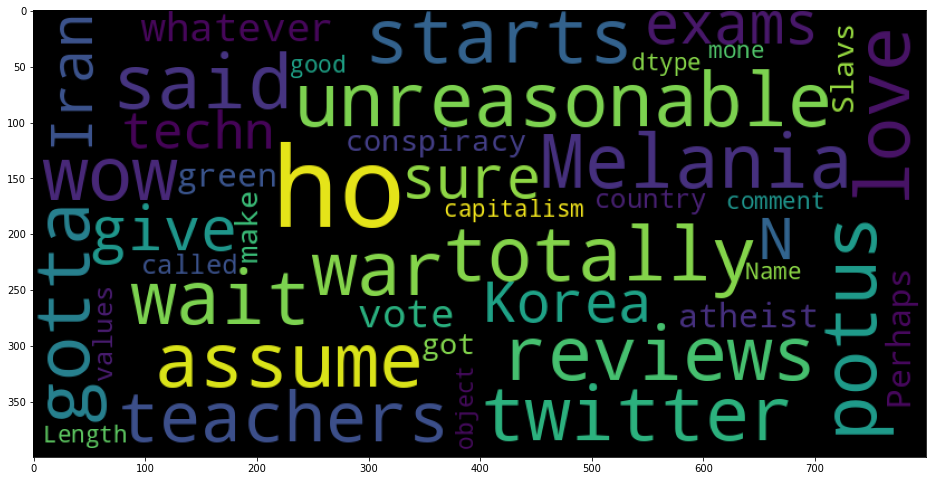

In [10]:
plt.figure(figsize = (16, 12))
wordcloud.generate(str(train.loc[train['label'] == 1, 'comment']))
plt.imshow(wordcloud)

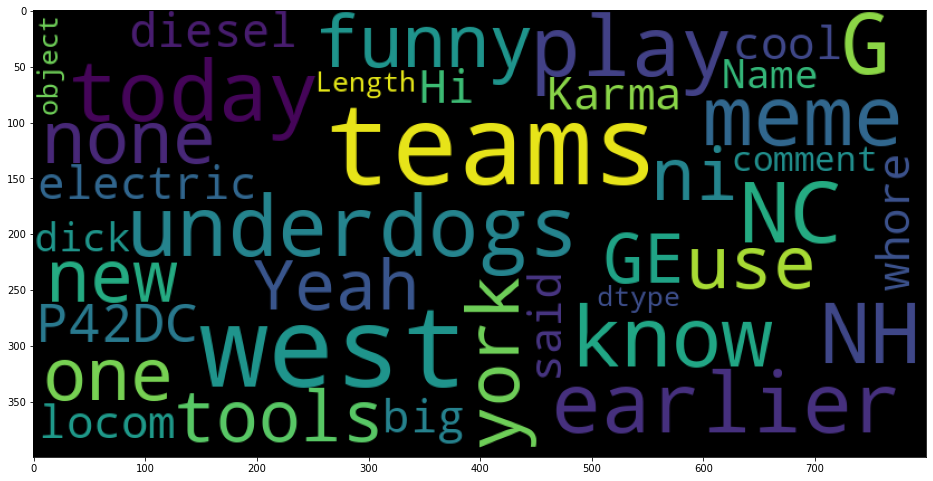

In [11]:
plt.figure(figsize=(16, 12))
wordcloud.generate(str(train.loc[train['label'] == 0, 'comment']))
plt.imshow(wordcloud)

Попытаемся найти какие-нибудь отклонения процентого соотношения сарказма

In [12]:
sub = train.groupby('subreddit')['label'].agg([np.size, np.mean, np.sum])
sub.sort_values(by = 'sum', ascending = False).head(10)

,size,mean,sum
subreddit,,,
AskReddit,65674,0.401453,26365
politics,39493,0.605348,23907
worldnews,26376,0.642516,16947
leagueoflegends,21034,0.542312,11407
pcmasterrace,18987,0.566651,10759
news,16891,0.603457,10193
funny,17939,0.451474,8099
pics,16152,0.484336,7823
todayilearned,14159,0.547567,7753


In [13]:
sub = train.groupby('author')['label'].agg([np.size, np.mean, np.sum])
sub[sub['size'] > 300].sort_values(by = 'mean', ascending = False).head(10)

,size,mean,sum
author,,,
NeonDisease,422,0.500000,211
ShyBiDude89,404,0.500000,202
ivsciguy,342,0.500000,171
mad-n-fla,318,0.500000,159
mindlessrabble,302,0.500000,151
pokemon_fetish,432,0.500000,216
Biffingston,845,0.499408,422


In [14]:
sub = train[train['score'] >= 0].groupby('score')['label'].agg([np.size, np.mean, np.sum])
sub[sub['size'] > 300].sort_values(by = 'mean', ascending = False).head(10)

,size,mean,sum
score,,,
0,58141,0.612752,35626
20,3096,0.561370,1738
34,1071,0.556489,596
26,1874,0.554429,1039
59,315,0.552381,174
18,3951,0.551759,2180
13,7277,0.546929,3980
17,4404,0.545867,2404
40,722,0.545706,394


In [15]:
sub = train[train['score'] < 0].groupby('score')['label'].agg([np.size, np.mean, np.sum])
sub[sub['size'] > 300].sort_values(by = 'mean', ascending = False).head(10)

,size,mean,sum
score,,,
-14,537,0.698324,375
-8,1852,0.696004,1289
-9,1503,0.691284,1039
-6,3088,0.688795,2127
-12,776,0.684278,531
-5,4134,0.678520,2805
-3,6736,0.676069,4554
-2,11924,0.675948,8060
-4,5436,0.673473,3661


### ЗАДАНИЕ 2 ОБУЧЕНИЕ МОДЕЛИ

Создание модели

In [16]:
# устанавливаем ограничение на максимальное число атрибутов и минимальную частоту слов
tf_idf = TfidfVectorizer(ngram_range = (1, 2), max_features = 50000, min_df = 2)
# создание логистической регрессии 
logit = LogisticRegression(C = 1, n_jobs = 4, solver = 'liblinear', random_state = 17, verbose = 1)
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf), ('logit', logit)])

Обучение модели

In [17]:
%%time
tfidf_logit_pipeline.fit(train_texts, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]iter  1 act 1.112e+05 pre 1.022e+05 delta 1.284e+02 f 5.255e+05 |g| 4.630e+03 CG  18
iter  2 act 5.243e+03 pre 4.699e+03 delta 1.284e+02 f 4.143e+05 |g| 3.707e+03 CG   5
iter  3 act 3.632e+03 pre 3.506e+03 delta 1.284e+02 f 4.091e+05 |g| 1.221e+03 CG  16
iter  4 act 2.480e+02 pre 2.463e+02 delta 1.284e+02 f 4.054e+05 |g| 2.992e+02 CG  20
iter  5 act 1.419e+01 pre 1.415e+01 delta 1.284e+02 f 4.052e+05 |g| 3.156e+01 CG  26
iter  6 act 2.230e-01 pre 2.229e-01 delta 1.284e+02 f 4.052e+05 |g| 3.352e+00 CG  30
iter  7 act 1.987e-03 pre 1.987e-03 delta 1.284e+02 f 4.052e+05 |g| 3.231e-01 CG  33
CPU times: user 1min 23s, sys: 35.9 s, total: 1min 59s
Wall time: 1min 3s


Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=50000, min_df=2,
                                 ngram_range=(1, 2))),
                ('logit',
                 LogisticRegression(C=1, n_jobs=4, random_state=17,
                                    solver='liblinear', verbose=1))])

Предскание модели

In [18]:
%%time
valid_pred = tfidf_logit_pipeline.predict(valid_texts)

CPU times: user 8.66 s, sys: 13.2 ms, total: 8.67 s
Wall time: 8.67 s


In [19]:
accuracy_score(y_valid, valid_pred)

0.7212715774810641

### ЗАДАНИЕ 3 ВИЗУАЛИЗАЦИЯ

In [20]:
def plot_confusion_matrix( actual, predicted, classes
                         , normalize = False
                         , title='Confusion matrix', figsize=(7,7)
                         , cmap=plt.cm.Blues, path_to_save_fig=None ):
    import itertools
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(actual, predicted).T
    if normalize: cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    
    plt.figure(figsize = figsize)
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    
    if path_to_save_fig:
        plt.savefig(path_to_save_fig, dpi=300, bbox_inches='tight')

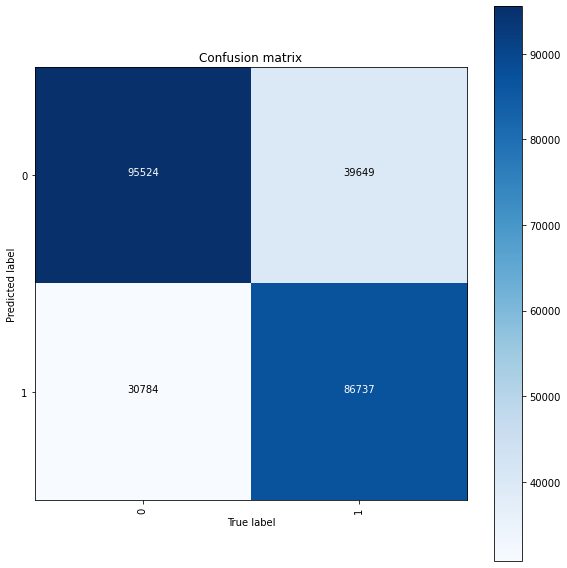

In [21]:
plot_confusion_matrix(y_valid, valid_pred, tfidf_logit_pipeline.named_steps['logit'].classes_, figsize=(8, 8))

In [22]:
import eli5
eli5.show_weights(estimator = tfidf_logit_pipeline.named_steps['logit'], vec = tfidf_logit_pipeline.named_steps['tf_idf'])

Weight?,Feature
+8.972,yes because
+7.491,obviously
+7.440,clearly
+7.121,yeah because
+6.764,totally
+6.186,because
+5.886,how dare
+5.397,right because
+5.170,good thing
+5.042,duh
